# Task 0: Warm Up

## Mount Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Unzip from Google Drive
#### The unzipped files are in colab disk and is assessible from the title of the zip file. In this case the file name is 'data-2019'

In [0]:
# !unzip -q "/content/drive/My Drive/Colab Notebooks/VehicleDetection/_data.zip"
!unzip "/content/drive/My Drive/Colab Notebooks/VehicleDetection/annot_folder.zip" -d "/content/drive/My Drive/Colab Notebooks/VehicleDetection/data4YOLO"

## CD into Base Path

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/VehicleDetection
# %cd /content/drive/My Drive/Colab Notebooks/VehicleDetection/data-2019/test

/content/drive/My Drive/Colab Notebooks/VehicleDetection


## Import Files

In [0]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving test_path.csv to test_path.csv


{'test_path.csv': b'guid/image\r\n0213ada8-e776-4404-9312-c264153c57c1/0000\r\n0213ada8-e776-4404-9312-c264153c57c1/0001\r\n0213ada8-e776-4404-9312-c264153c57c1/0002\r\n0213ada8-e776-4404-9312-c264153c57c1/0003\r\n0213ada8-e776-4404-9312-c264153c57c1/0004\r\n0213ada8-e776-4404-9312-c264153c57c1/0005\r\n0213ada8-e776-4404-9312-c264153c57c1/0006\r\n0213ada8-e776-4404-9312-c264153c57c1/0007\r\n0213ada8-e776-4404-9312-c264153c57c1/0008\r\n0213ada8-e776-4404-9312-c264153c57c1/0009\r\n0213ada8-e776-4404-9312-c264153c57c1/0010\r\n0213ada8-e776-4404-9312-c264153c57c1/0011\r\n0213ada8-e776-4404-9312-c264153c57c1/0012\r\n0213ada8-e776-4404-9312-c264153c57c1/0013\r\n0213ada8-e776-4404-9312-c264153c57c1/0014\r\n0213ada8-e776-4404-9312-c264153c57c1/0015\r\n0213ada8-e776-4404-9312-c264153c57c1/0016\r\n0213ada8-e776-4404-9312-c264153c57c1/0017\r\n0213ada8-e776-4404-9312-c264153c57c1/0018\r\n0213ada8-e776-4404-9312-c264153c57c1/0019\r\n0213ada8-e776-4404-9312-c264153c57c1/0020\r\n0213ada8-e776-4404-93

## Show Sample Image (from Darknet folder)

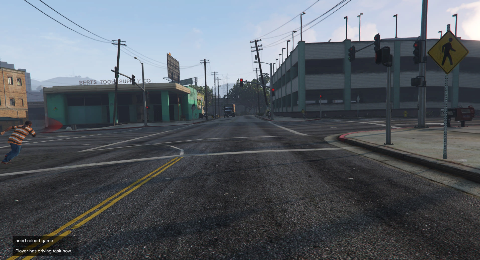

The original shape of the image is: (1052, 1914, 3)
The resized shape of the image is: (260, 480, 3)


In [4]:
import cv2
from google.colab.patches import cv2_imshow 
image = cv2.imread('data4YOLO/image_folder/00000_image.jpg')
image_resize = cv2.resize(image,(480, 260));
cv2_imshow(image_resize)
print('The original shape of the image is:', image.shape)
print('The resized shape of the image is:', image_resize.shape)

# Task 1: YOLOv3

## Step 1: Import Required Libraries

In [5]:
# YOLO v3
import os

import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.models import load_model, Model
from keras.layers.merge import add, concatenate
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

Using TensorFlow backend.


## Step 5: Set up the variables


In [0]:
net_h, net_w = 416, 416
obj_thresh, nms_thresh = 0.5, 0.45
anchors = [[22,22, 33,54, 54,34], [68,89, 105,190, 156,29], [160,96, 188,274, 243,495]]
# labels = ["Compacts", "Sedans", "SUVs", "Coupes", "Muscle", "SportsClassics", "Sports", "Super", "Motorcycles", "OffRoad", "Industrial", "Utility", "Vans", "Cycles", "Service", "Emergency", "Commercial", "Trains"]
labels = ["0", "1", "2", "3"]

### Step 6b: Load the yolo model

In [7]:
# yolov3 = load_model('yolov3.h5')
yolov3 = load_model('keras-yolo3-master/yolo_ROB535.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Step 7: Loading the image into the right input shape of 416 x 416

In [0]:
def preprocess_input(image, net_h, net_w):
    new_h, new_w, _ = image.shape

    # determine the new size of the image
    if (float(net_w)/new_w) < (float(net_h)/new_h):
        new_h = (new_h * net_w)//new_w
        new_w = net_w
    else:
        new_w = (new_w * net_h)//new_h
        new_h = net_h

    # resize the image to the new size
    resized = cv2.resize(image[:,:,::-1]/255., (new_w, new_h))

    # embed the image into the standard letter box
    new_image = np.ones((net_h, net_w, 3)) * 0.5
    new_image[(net_h-new_h)//2:(net_h+new_h)//2, (net_w-new_w)//2:(net_w+new_w)//2, :] = resized
    new_image = np.expand_dims(new_image, 0)

    return new_image

## Step 8: Create a class for the Bounding Box.

In [0]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

## Step 9: Define Functions For ETC
*   Interval overlap — checks if two intervals overlap. Two intervals do not overlap when one ends before the other begins.
*   Intersection over Union(IoU) of two boxes
*   Non-Max Suppression which takes boxes that have the presence of objects in them along with non-max threshold as a parameter
*   Sigmoid function

In [0]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

## Step 10: Decode the output of the network
We will iterate through each of the each one of the NumPy arrays, one at a time and decode the candidate bounding boxes and class predictions based on the object threshold.
The first 4 elements will be the coordinates of the Bounding box, 5th element will be object score followed by the class probabilities

In [0]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i // grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[row, col, b, 4]
            
            if(objectness <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[row,col,b,:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[row,col,b,5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)

            boxes.append(box)

    return boxes

In [0]:
def get_yolo_boxes(model, images, net_h, net_w, anchors, obj_thresh, nms_thresh):
    image_h, image_w, _ = images[0].shape
    nb_images           = len(images)
    batch_input         = np.zeros((nb_images, net_h, net_w, 3))

    # preprocess the input
    for i in range(nb_images):
        batch_input[i] = preprocess_input(images[i], net_h, net_w)        

    # run the prediction
    batch_output = model.predict_on_batch(batch_input)
    batch_boxes  = [None]*nb_images

    for i in range(nb_images):
        yolos = [batch_output[0][i], batch_output[1][i], batch_output[2][i]]
        boxes = []

        # decode the output of the network
        for j in range(len(yolos)):
            yolo_anchors = anchors[(2-j)*6:(3-j)*6] # config['model']['anchors']
            boxes += decode_netout(yolos[j], yolo_anchors, obj_thresh, net_h, net_w)

        # correct the sizes of the bounding boxes
        correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

        # suppress non-maximal boxes
        do_nms(boxes, nms_thresh)        
           
        batch_boxes[i] = boxes

    return batch_boxes        

## Step 11: Correcting the Yolo boxes.
We have the bounding boxes but they need to be stretched back into the shape of the original image. This will allow plotting the original image and draw the bounding boxes, detecting real objects.

In [0]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
  if (float(net_w)/image_w) < (float(net_h)/image_h):
    new_w = net_w
    new_h = (image_h*net_w)/image_w
  else:
    new_h = net_w
    new_w = (image_w*net_h)/image_h

  for i in range(len(boxes)):
    x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
    y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h

    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

## Step 12: Get all boxes above the specified threshold.
**get_boxes function** takes the list of boxes, labels, and threshold as arguments and returns parallel lists of boxes, labels, and scores.

In [0]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

## Step 12: Drawing a white box around the object present in the image.

In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

def draw_boxes(filename, v_boxes, v_labels, v_scores):
  fig= plt.figure(figsize=(11,8))
  # load the image
  data = plt.imread(filename)
  # plot the image
  plt.imshow(data)
  # get the context for drawing boxes
  ax = plt.gca()
  # plot each box
  for i in range(len(v_boxes)):
    box = v_boxes[i]
    # get coordinates
    y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
    # calculate width and height of the box
    width, height = x2 - x1, y2 - y1
    # create the shape
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    # draw the box
    ax.add_patch(rect)
    # draw text and score in top left corner
    label = "%s (%.3f)" % (v_labels[i], v_scores[i])
    plt.text(x1, y1, label, color='red')
    # show the plot
  plt.show()

# DO YOLO

## Image with Bounding Box

[(1, 13, 13, 27), (1, 26, 26, 27), (1, 52, 52, 27)]
1 99.24901723861694


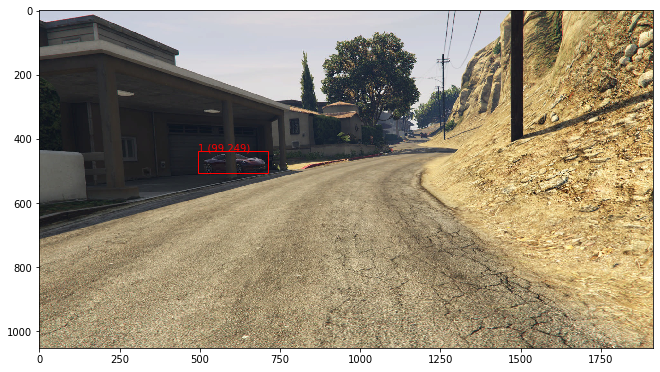

In [19]:
from numpy import expand_dims
import pdb

# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'data4YOLO/image_folder/04756_image.jpg'
photo_filename = 'data4YOLO/image_folder/00082_image.jpg'
photo_filename = 'data4YOLO/image_folder/00098_image.jpg'
photo_filename = 'data4YOLO/image_folder/00107_image.jpg'
# photo_filename = 'data4YOLO/image_folder/00020_image.jpg'
# photo_filename = 'data4YOLO/image_folder/00058_image.jpg'
# load and prepare image
image = cv2.imread(photo_filename)
image_h, image_w, _ = image.shape
process_image = preprocess_input(image, net_h, net_w)
# make prediction
yolos = yolov3.predict(process_image)

# summarize the shape of the list of arrays
print([a.shape for a in yolos])

# define the anchors
anchors = [17,20, 32,54, 34,26, 63,57, 66,391, 70,114, 117,147, 141,243, 252,330]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()

for i in range(len(yolos)):
    # pdb.set_trace()
    yolo_anchors = anchors[(2-i)*6:(3-i)*6]
    boxes += decode_netout(np.squeeze(yolos[i]), yolo_anchors, obj_thresh,  net_h, net_w)

# correct the sizes of the bounding boxes
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

# suppress non-maximal boxes
do_nms(boxes, nms_thresh)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

% Run through test and produce the csv

In [30]:
import numpy as np
from glob import glob
import csv
from random import randint
pred_labels = []
xmins = []
xmaxs = []
ymins = []
ymaxs = []
count = 0
with open('data/data-2019/test/test_path.csv') as csvfile:
    # set_trace()
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        # if count != 603:
        image = cv2.imread('data/data-2019/test/' + line[0] + '_image.jpg')
        image_h, image_w, _ = image.shape
        process_image = preprocess_input(image, net_h, net_w)
        # make prediction
        yolos = yolov3.predict(process_image)

        # define the anchors
        anchors = [17,20, 32,54, 34,26, 63,57, 66,391, 70,114, 117,147, 141,243, 252,330]
        # define the probability threshold for detected objects
        class_threshold = 0.6
        boxes = list()

        for i in range(len(yolos)):
            # pdb.set_trace()
            yolo_anchors = anchors[(2-i)*6:(3-i)*6]
            boxes += decode_netout(np.squeeze(yolos[i]), yolo_anchors, obj_thresh,  net_h, net_w)

        # correct the sizes of the bounding boxes
        correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

        # suppress non-maximal boxes
        do_nms(boxes, nms_thresh)

        # get the details of the detected objects
        v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
        if count % 50 == 0:
            print(count)
        else:
          print(count, end=" ")
        if (len(v_labels) != 0):
            if (v_labels[0] == "0"):
                pred_label = 0
            elif (v_labels[0] == "1"):
                if ((v_boxes[0].xmax - v_boxes[0].xmin) < 75 and (v_boxes[0].ymax - v_boxes[0].ymin) < 50):
                    pred_label = 0
                elif ((v_boxes[0].xmax - v_boxes[0].xmin) < 50 and (v_boxes[0].ymax - v_boxes[0].ymin) < 70):
                    pred_label = 0
                elif ((v_boxes[0].ymax - v_boxes[0].ymin) < 38):
                    pred_label = 0
                else:
                    pred_label = 1
            elif (v_labels[0] == "2"):
                pred_label = 2
            elif (v_labels[0] == "3"):
                pred_label = 3
            pred_labels.append(pred_label)
            xmins.append(v_boxes[0].xmin)
            xmaxs.append(v_boxes[0].xmax)
            ymins.append(v_boxes[0].ymin)
            ymaxs.append(v_boxes[0].ymax)
        else:
            pred_labels.append(0)
            xmins.append(0)
            xmaxs.append(0)
            ymins.append(0)
            ymaxs.append(0)
        count += 1
        # if (count > 30):
        #   break
    # set_trace()
print(pred_labels)
################################ Generating CSV ################################
files = glob('data/data-2019/test/*/*_image.jpg')
files.sort()
name = 'data/data-2019/test/test_labels_13_bounds.csv'
cnt = 0
with open(name, 'w') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow(['guid/image', 'label'])
    for file in files:
        guid = file.split('/')[-2]
        idx = file.split('/')[-1].replace('_image.jpg', '')
        # set_trace()
        label = pred_labels[cnt]
        xmin = xmins[cnt]
        xmax = xmaxs[cnt]
        ymin = ymins[cnt]
        ymax = ymaxs[cnt]
        writer.writerow(['{}/{}'.format(guid, idx), label, xmin, xmax, ymin, ymax])
        cnt += 1
        # if (cnt > count):
        #   break
print('Wrote report file `{}`'.format(name))

0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250
251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27